In [35]:
import requests
import json
from elasticsearch import Elasticsearch
import pandas as pd
from IPython.display import display, Image as IPImage
import os

# Configuration
# API_URL = "http://localhost:8000"
API_URL = "http://200.135.58.46:8000"
# ES_URL = "http://localhost:9200"
# ES_INDEX = "face_embeddings"

# Initialize Elasticsearch client
# es = Elasticsearch([ES_URL])

In [5]:
response = requests.get(f"{API_URL}/health")
print(json.dumps(response.json(), indent=2))

{
  "status": "healthy",
  "elasticsearch": "connected"
}


In [7]:
# Check if Elasticsearch is connected
if es.ping():
    print("✓ Elasticsearch is connected")

    # Get cluster info
    info = es.info()
    print(f"\nCluster Name: {info['cluster_name']}")
    print(f"Version: {info['version']['number']}")
else:
    print("✗ Elasticsearch connection failed")

✓ Elasticsearch is connected

Cluster Name: docker-cluster
Version: 8.11.0


In [8]:
# Check if index exists
if es.indices.exists(index=ES_INDEX):
    print(f"✓ Index '{ES_INDEX}' exists\n")

    # Get index mapping
    mapping = es.indices.get_mapping(index=ES_INDEX)
    print("Index Mapping:")
    print(json.dumps(mapping[ES_INDEX]["mappings"], indent=2))
else:
    print(f"✗ Index '{ES_INDEX}' does not exist")

✓ Index 'face_embeddings' exists

Index Mapping:
{
  "properties": {
    "embedding": {
      "type": "dense_vector",
      "dims": 4096,
      "index": true,
      "similarity": "cosine"
    },
    "name": {
      "type": "text"
    },
    "person_id": {
      "type": "keyword"
    },
    "timestamp": {
      "type": "date"
    }
  }
}


In [8]:
# Get document count
count = es.count(index=ES_INDEX)
print(f"Total documents in index: {count['count']}")

Total documents in index: 0



Storing face for: Cariani (ID: cariani_1)


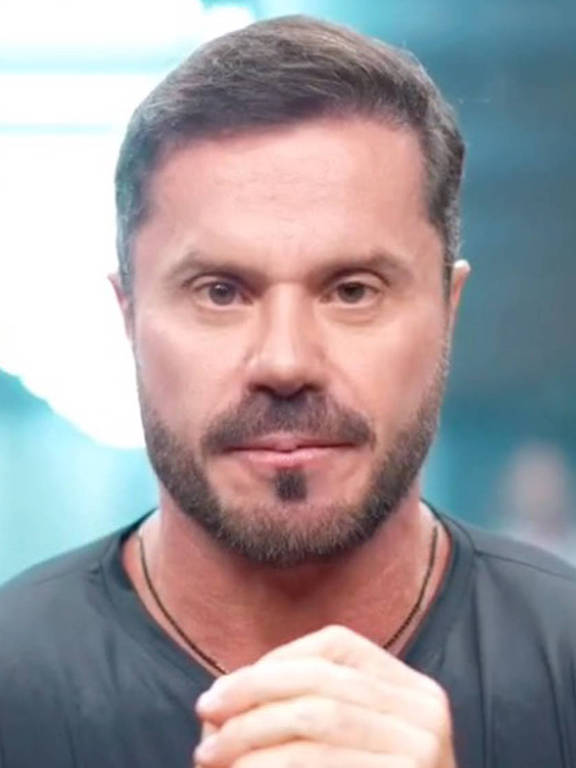

✓ Success! Stored as document ID: qztrzpkB4m-u4EMaOefy

Storing face for: Brad (ID: brad_1)


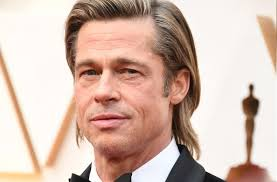

✓ Success! Stored as document ID: rDtrzpkB4m-u4EMaP-dj

Storing face for: Julia (ID: julia_1)


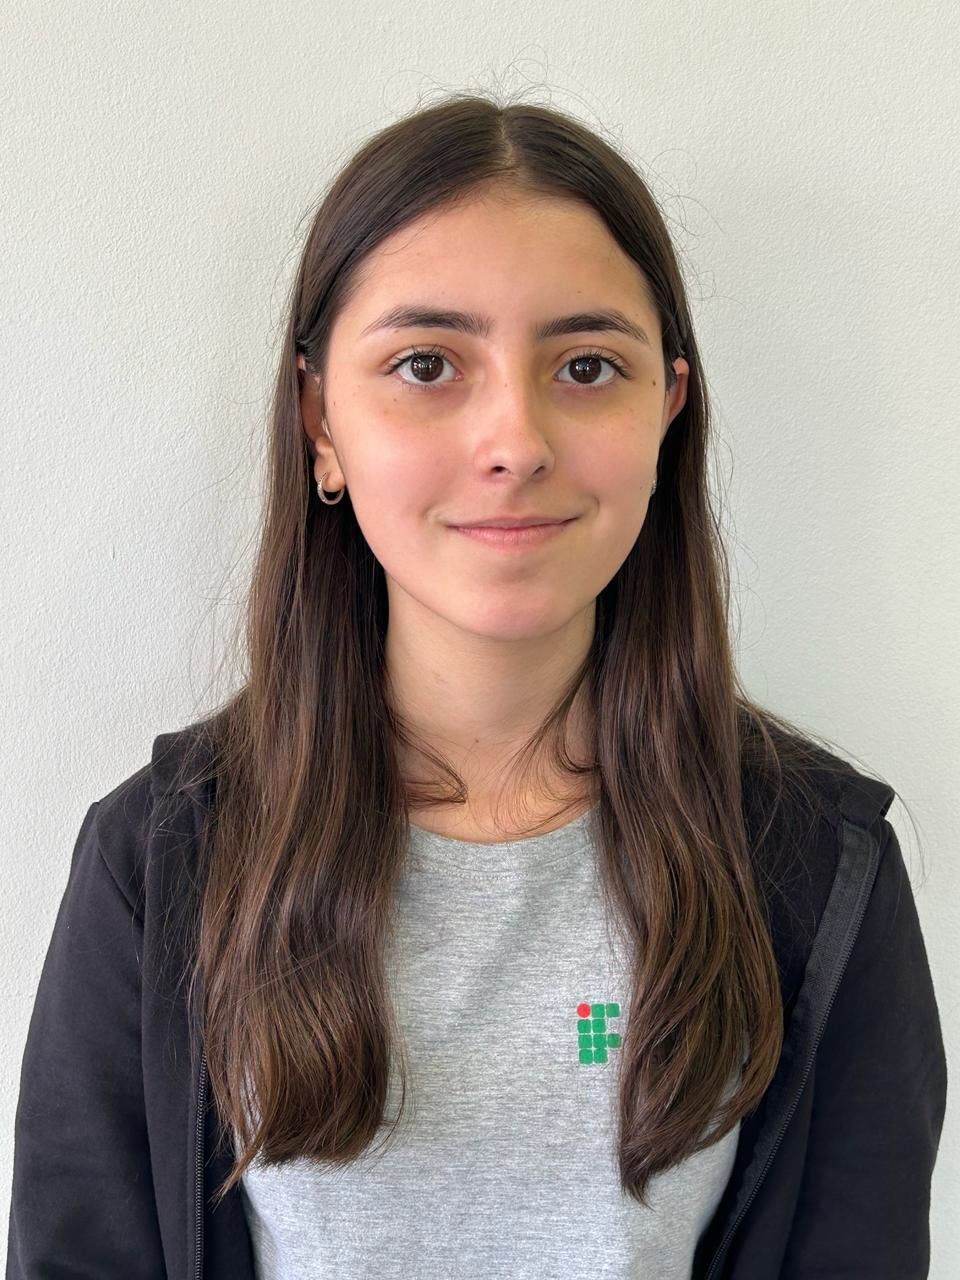

✓ Success! Stored as document ID: rTtrzpkB4m-u4EMaSudX

Storing face for: Manuela (ID: manu_1)


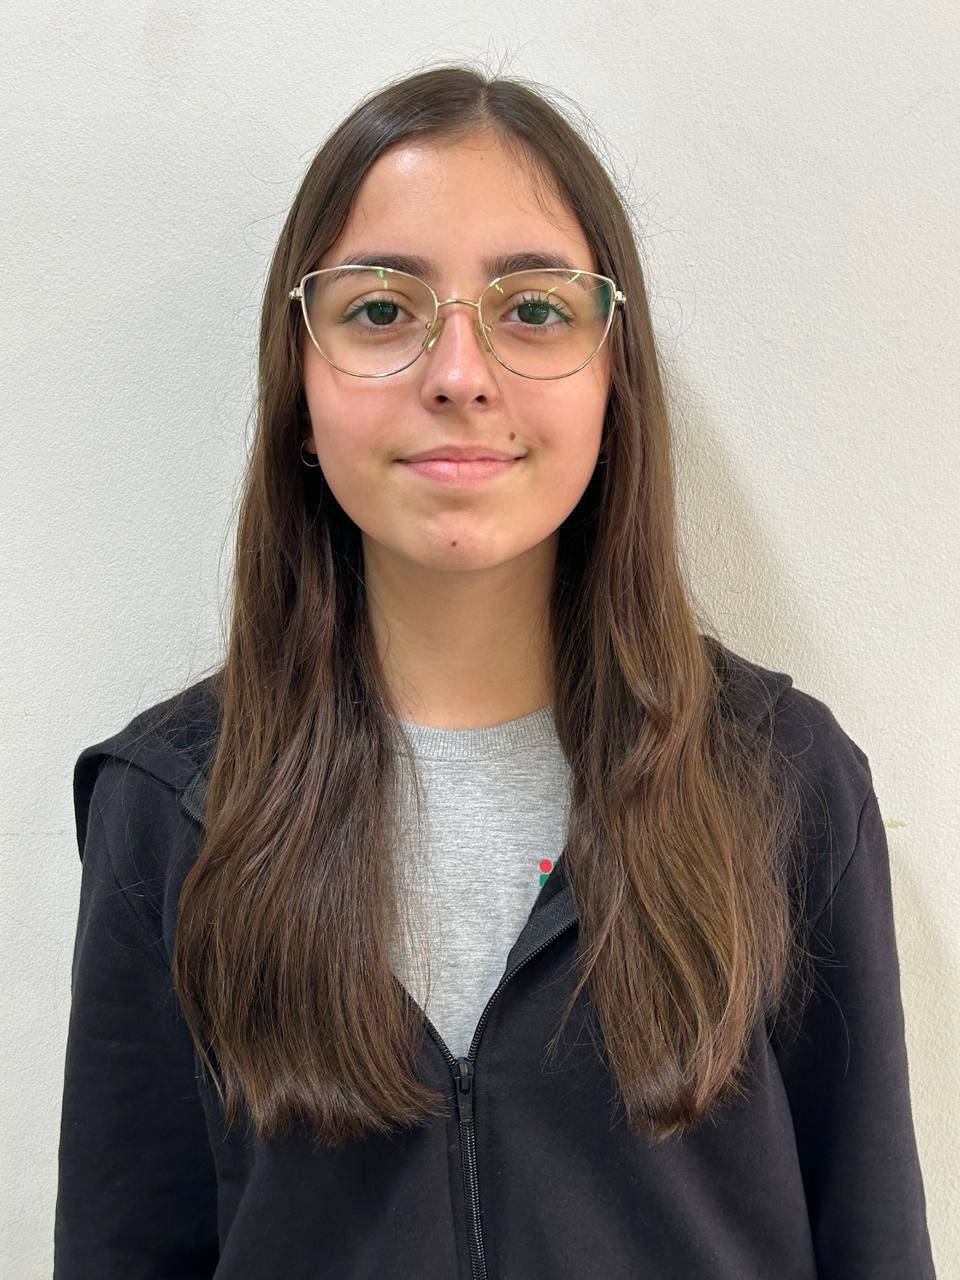

✓ Success! Stored as document ID: rjtrzpkB4m-u4EMaVeeq


{'message': 'Face stored successfully',
 'person_id': 'manu_1',
 'name': 'Manuela',
 'es_id': 'rjtrzpkB4m-u4EMaVeeq'}

In [36]:
# Function to store a face
def store_face(image_path, person_id, name):
    """
    Store a face in the system
    """
    if not os.path.exists(image_path):
        print(f"✗ Image not found: {image_path}")
        return None

    # Display the image
    print(f"\nStoring face for: {name} (ID: {person_id})")
    display(IPImage(filename=image_path, width=200))

    # Send request
    with open(image_path, "rb") as img:
        files = {"file": img}
        data = {"person_id": person_id, "name": name}
        response = requests.post(f"{API_URL}/store", files=files, data=data)

    if response.status_code == 200:
        result = response.json()
        print(f"✓ Success! Stored as document ID: {result['es_id']}")
        return result
    else:
        print(f"✗ Error: {response.status_code}")
        print(response.json())
        return None


store_face("server/cariani_1.jpg", "cariani_1", "Cariani")
store_face("server/brad_1.jpg", "brad_1", "Brad")
store_face("server/julia.jpeg", "julia_1", "Julia")
store_face("server/manuela.jpeg", "manu_1", "Manuela")
# store_face('server/cariani_2.jpg', 'cariani_2', 'Cariani')

In [10]:
def get_all_people():
    """
    Retrieve all people stored in the index
    """
    query = {
        "query": {"match_all": {}},
        "_source": ["person_id", "name", "timestamp"],
        "size": 1000,  # Adjust if you have more documents
    }

    response = es.search(index=ES_INDEX, body=query)

    people = []
    for hit in response["hits"]["hits"]:
        people.append(
            {
                "ES Document ID": hit["_id"],
                "Person ID": hit["_source"]["person_id"],
                "Name": hit["_source"]["name"],
                "Timestamp": hit["_source"]["timestamp"],
            }
        )

    return pd.DataFrame(people)


# Display all people
df_people = get_all_people()
print(f"\nTotal people in database: {len(df_people)}\n")
display(df_people)


Total people in database: 2



,ES Document ID,Person ID,Name,Timestamp
0,hUZ8wJkBveiXSaUdGBKx,cariani_1,Cariani,2025-10-07T21:03:02Z
1,hkZ8wJkBveiXSaUdGhKy,brad_1,Brad,2025-10-07T21:03:02Z


In [ ]:
def get_person_details(person_id):
    """
    Get detailed information about a specific person
    """
    query = {"query": {"term": {"person_id": person_id}}}

    response = es.search(index=ES_INDEX, body=query)

    if response["hits"]["hits"]:
        hit = response["hits"]["hits"][0]
        print(f"Person ID: {hit['_source']['person_id']}")
        print(f"Name: {hit['_source']['name']}")
        print(f"Timestamp: {hit['_source']['timestamp']}")
        print(f"Embedding dimensions: {len(hit['_source']['embedding'])}")
        print(f"First 10 embedding values: {hit['_source']['embedding'][:10]}")
    else:
        print(f"No person found with ID: {person_id}")


# Example usage
# get_person_details('person_001')


Recognizing face from: server/brad_1.jpg


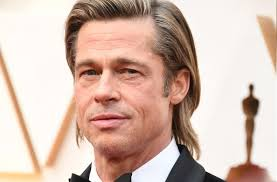


RECOGNITION RESULTS

🎯 BEST MATCH:
   Name: Brad
   Person ID: brad_1
   Similarity Score: 1.0000
   Stored: 2025-10-10T13:59:19Z

📊 ALL MATCHES (Top 4):


,person_id,name,similarity_score,timestamp
0,brad_1,Brad,1.000000,2025-10-10T13:59:19Z
1,cariani_1,Cariani,0.645911,2025-10-10T13:59:17Z
2,julia_1,Julia,0.468975,2025-10-10T13:59:21Z
3,manu_1,Manuela,0.458619,2025-10-10T13:59:24Z


{'message': 'Face recognition completed',
 'best_match': {'person_id': 'brad_1',
  'name': 'Brad',
  'similarity_score': 1.0,
  'timestamp': '2025-10-10T13:59:19Z'},
 'all_matches': [{'person_id': 'brad_1',
   'name': 'Brad',
   'similarity_score': 1.0,
   'timestamp': '2025-10-10T13:59:19Z'},
  {'person_id': 'cariani_1',
   'name': 'Cariani',
   'similarity_score': 0.6459112,
   'timestamp': '2025-10-10T13:59:17Z'},
  {'person_id': 'julia_1',
   'name': 'Julia',
   'similarity_score': 0.46897486,
   'timestamp': '2025-10-10T13:59:21Z'},
  {'person_id': 'manu_1',
   'name': 'Manuela',
   'similarity_score': 0.45861906,
   'timestamp': '2025-10-10T13:59:24Z'}]}

In [ ]:
def recognize_face(image_path):
    """
    Recognize a face from an image
    """
    if not os.path.exists(image_path):
        print(f"✗ Image not found: {image_path}")
        return None

    print(f"\nRecognizing face from: {image_path}")
    display(IPImage(filename=image_path, width=200))

    # Send request
    with open(image_path, "rb") as img:
        files = {"file": img}
        response = requests.post(f"{API_URL}/recognize", files=files)

    if response.status_code == 200:
        result = response.json()

        if result["all_matches"]:
            print("\n" + "=" * 60)
            print("RECOGNITION RESULTS")
            print("=" * 60)

            # Best match
            best = result["best_match"]
            print(f"\n🎯 BEST MATCH:")
            print(f"   Name: {best['name']}")
            print(f"   Person ID: {best['person_id']}")
            print(f"   Similarity Score: {best['similarity_score']:.4f}")
            print(f"   Stored: {best['timestamp']}")

            # All matches
            print(f"\n📊 ALL MATCHES (Top {len(result['all_matches'])}):")
            df_matches = pd.DataFrame(result["all_matches"])
            display(df_matches)
        else:
            print("\n❌ No matching face found in the database")

        return result
    else:
        print(f"✗ Error: {response.status_code}")
        print(response.json())
        return None


# Example usage - Replace with your actual image path
recognize_face('server/brad_2.jpg')


In [ ]:
def batch_store_faces(faces_list):
    """
    Store multiple faces at once

    Args:
        faces_list: List of tuples (image_path, person_id, name)
    """
    results = []

    for image_path, person_id, name in faces_list:
        print(f"\n{'=' * 60}")
        result = store_face(image_path, person_id, name)
        results.append(result)

    print(f"\n{'=' * 60}")
    print(f"✓ Completed storing {len(results)} faces")
    successful = sum(1 for r in results if r is not None)
    print(f"✓ Successful: {successful}/{len(results)}")

    return results


# Example usage
# faces_to_store = [
#     ('images/person1.jpg', 'person_001', 'John Doe'),
#     ('images/person2.jpg', 'person_002', 'Jane Smith'),
#     ('images/person3.jpg', 'person_003', 'Bob Johnson'),
# ]
# batch_store_faces(faces_to_store)

In [ ]:
def batch_recognize_faces(image_paths):
    """
    Recognize multiple faces

    Args:
        image_paths: List of image paths to recognize
    """
    results = []

    for image_path in image_paths:
        print(f"\n{'=' * 60}")
        result = recognize_face(image_path)
        results.append(result)

    return results


# Example usage
# test_images = [
#     'images/test1.jpg',
#     'images/test2.jpg',
#     'images/test3.jpg',
# ]
# batch_recognize_faces(test_images)

In [ ]:
def delete_person(person_id):
    """
    Delete a person from the index
    """
    query = {"query": {"term": {"person_id": person_id}}}

    response = es.delete_by_query(index=ES_INDEX, body=query)
    print(f"Deleted {response['deleted']} document(s) for person_id: {person_id}")


# Example usage
# delete_person('person_001')

In [ ]:
def delete_all_documents():
    """
    ⚠️ WARNING: This deletes ALL documents from the index!
    """
    confirm = input(
        "Are you sure you want to delete ALL documents? Type 'yes' to confirm: "
    )

    if confirm.lower() == "yes":
        query = {"query": {"match_all": {}}}

        response = es.delete_by_query(index=ES_INDEX, body=query)
        print(f"✓ Deleted {response['deleted']} document(s)")
    else:
        print("Deletion cancelled")


# Uncomment to use
# delete_all_documents()

In [ ]:
def get_statistics():
    """
    Get statistics about the face database
    """
    # Total count
    count = es.count(index=ES_INDEX)["count"]

    # Get all people
    query = {
        "query": {"match_all": {}},
        "_source": ["person_id", "name", "timestamp"],
        "size": 1000,
    }
    response = es.search(index=ES_INDEX, body=query)

    # Unique people
    unique_people = set(hit["_source"]["person_id"] for hit in response["hits"]["hits"])

    print("📊 DATABASE STATISTICS")
    print("=" * 60)
    print(f"Total Documents: {count}")
    print(f"Unique People: {len(unique_people)}")
    print(
        f"Average documents per person: {count / len(unique_people):.2f}"
        if unique_people
        else "N/A"
    )

    # Most recent additions
    if response["hits"]["hits"]:
        recent_query = {
            "query": {"match_all": {}},
            "_source": ["person_id", "name", "timestamp"],
            "sort": [{"timestamp": {"order": "desc"}}],
            "size": 5,
        }
        recent = es.search(index=ES_INDEX, body=recent_query)

        print(f"\n🕐 RECENT ADDITIONS (Last 5):")
        for hit in recent["hits"]["hits"]:
            src = hit["_source"]
            print(f"   {src['name']} ({src['person_id']}) - {src['timestamp']}")


get_statistics()